In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('bank.csv')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


The dataset has 11162 rows and 17 features

# Understanding the Dataset

Age:- Age of the customer

Job:- Job of the customer

Marital:- Marital status of the customer (Married or unmarried)

Education:- Education level of the customer

Default:- Has ever defaulted in credit

Balance:- Account Balance

Housing:- If the client has housing loan with the bank

Loan:- If the client has personal loan with the bank

Contact:- Mode of communication

Month:- Month when last contacted

Day:- Day when last contacted

Duration:- Duration of last contact in seconds

Campaign:- Number of times the person was contacted during the current campaign

pdays:- number of days since client was last contacted after the previous campaign

previous:- Number of times the person was contacted during the previous campaigns

poutcome:- outcome of the previous campaign

deposit:- does the client have a deposit with the bank

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [5]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


* Mean age in the data is 41. Min age is 18 and the maxiumum age is 95.

* Mean bank balance of customers is 1528.54. The lowest balance is -6847 and the highest balance is 81204.

In [6]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

There are no missing values in the data.

In [7]:
df.duplicated().sum()

np.int64(0)

There are is duplicate data.

Checking the values in each column

In [8]:
for column in df.columns:
    print(f"Unique values in {column}:")
    print(df[column].unique(),"\n")

Unique values in age:
[59 56 41 55 54 42 60 37 28 38 30 29 46 31 35 32 49 43 26 40 33 23 48 45
 36 52 53 39 57 51 44 24 50 27 34 47 25 58 61 68 75 22 69 66 85 72 90 67
 71 21 74 65 62 83 70 76 77 19 73 63 20 78 95 64 79 82 18 86 84 87 92 81
 80 93 88 89] 

Unique values in job:
['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student'] 

Unique values in marital:
['married' 'single' 'divorced'] 

Unique values in education:
['secondary' 'tertiary' 'primary' 'unknown'] 

Unique values in default:
['no' 'yes'] 

Unique values in balance:
[2343   45 1270 ... 1594 2593 -134] 

Unique values in housing:
['yes' 'no'] 

Unique values in loan:
['no' 'yes'] 

Unique values in contact:
['unknown' 'cellular' 'telephone'] 

Unique values in day:
[ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24  1 10 22 25 31] 

Unique values in month:
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 

In [9]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [10]:
df.deposit.value_counts()

deposit
no     5873
yes    5289
Name: count, dtype: int64

The dataset is balanced

Lets check the distribution of the data

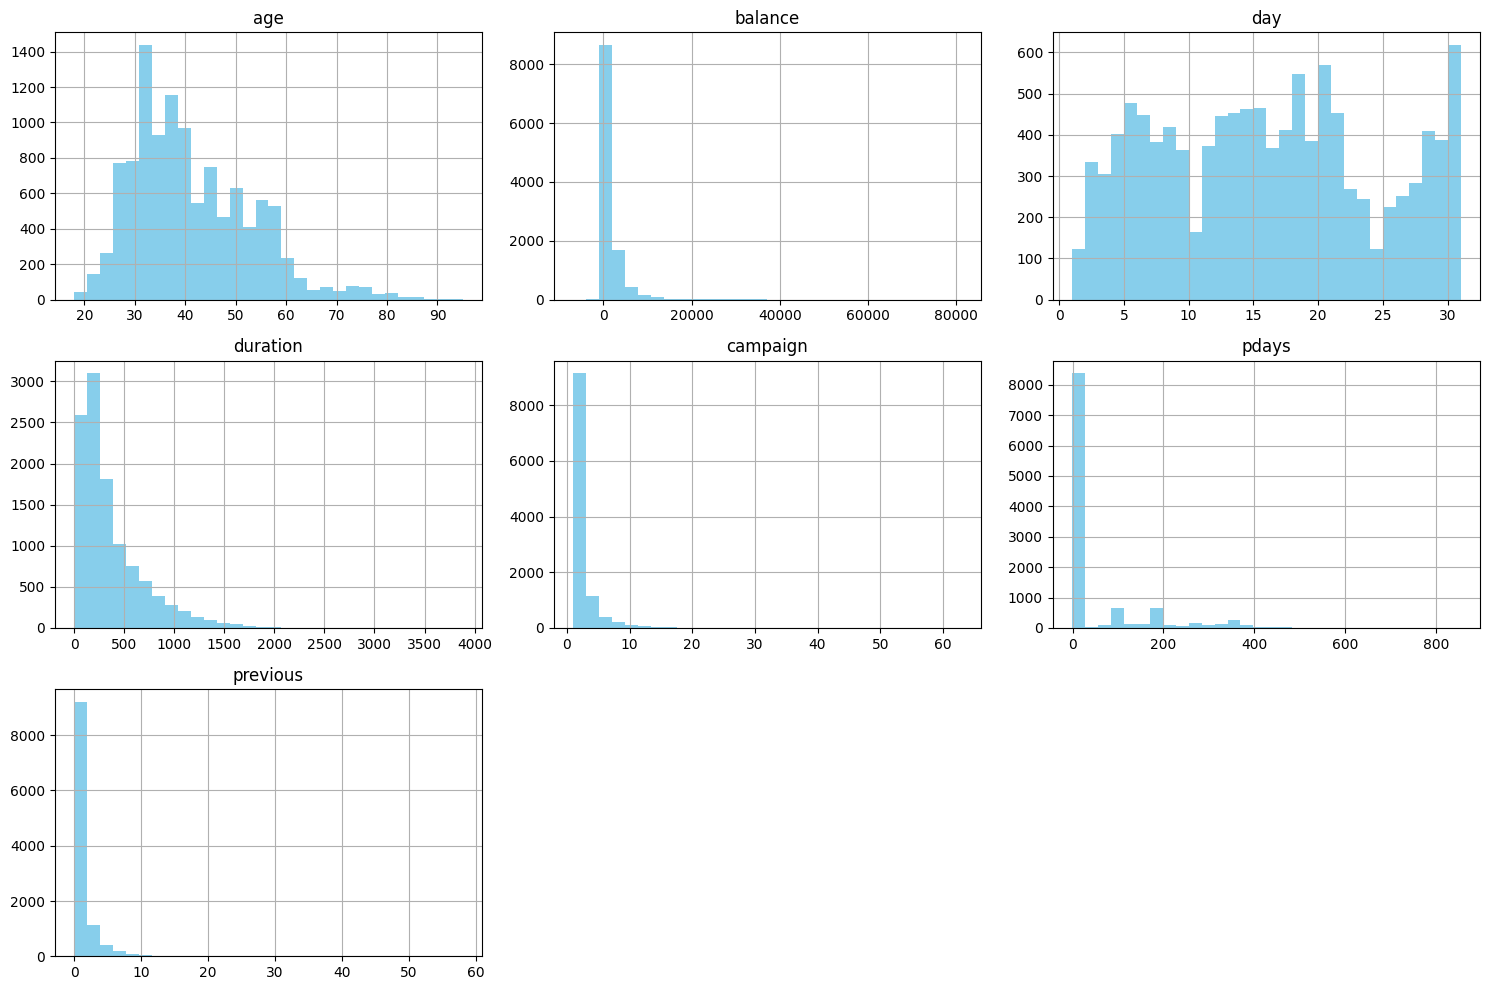

In [56]:
df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
for ax in plt.gcf().axes:
    for patch in ax.patches:
        patch.set_facecolor('skyblue')
plt.show()

* 

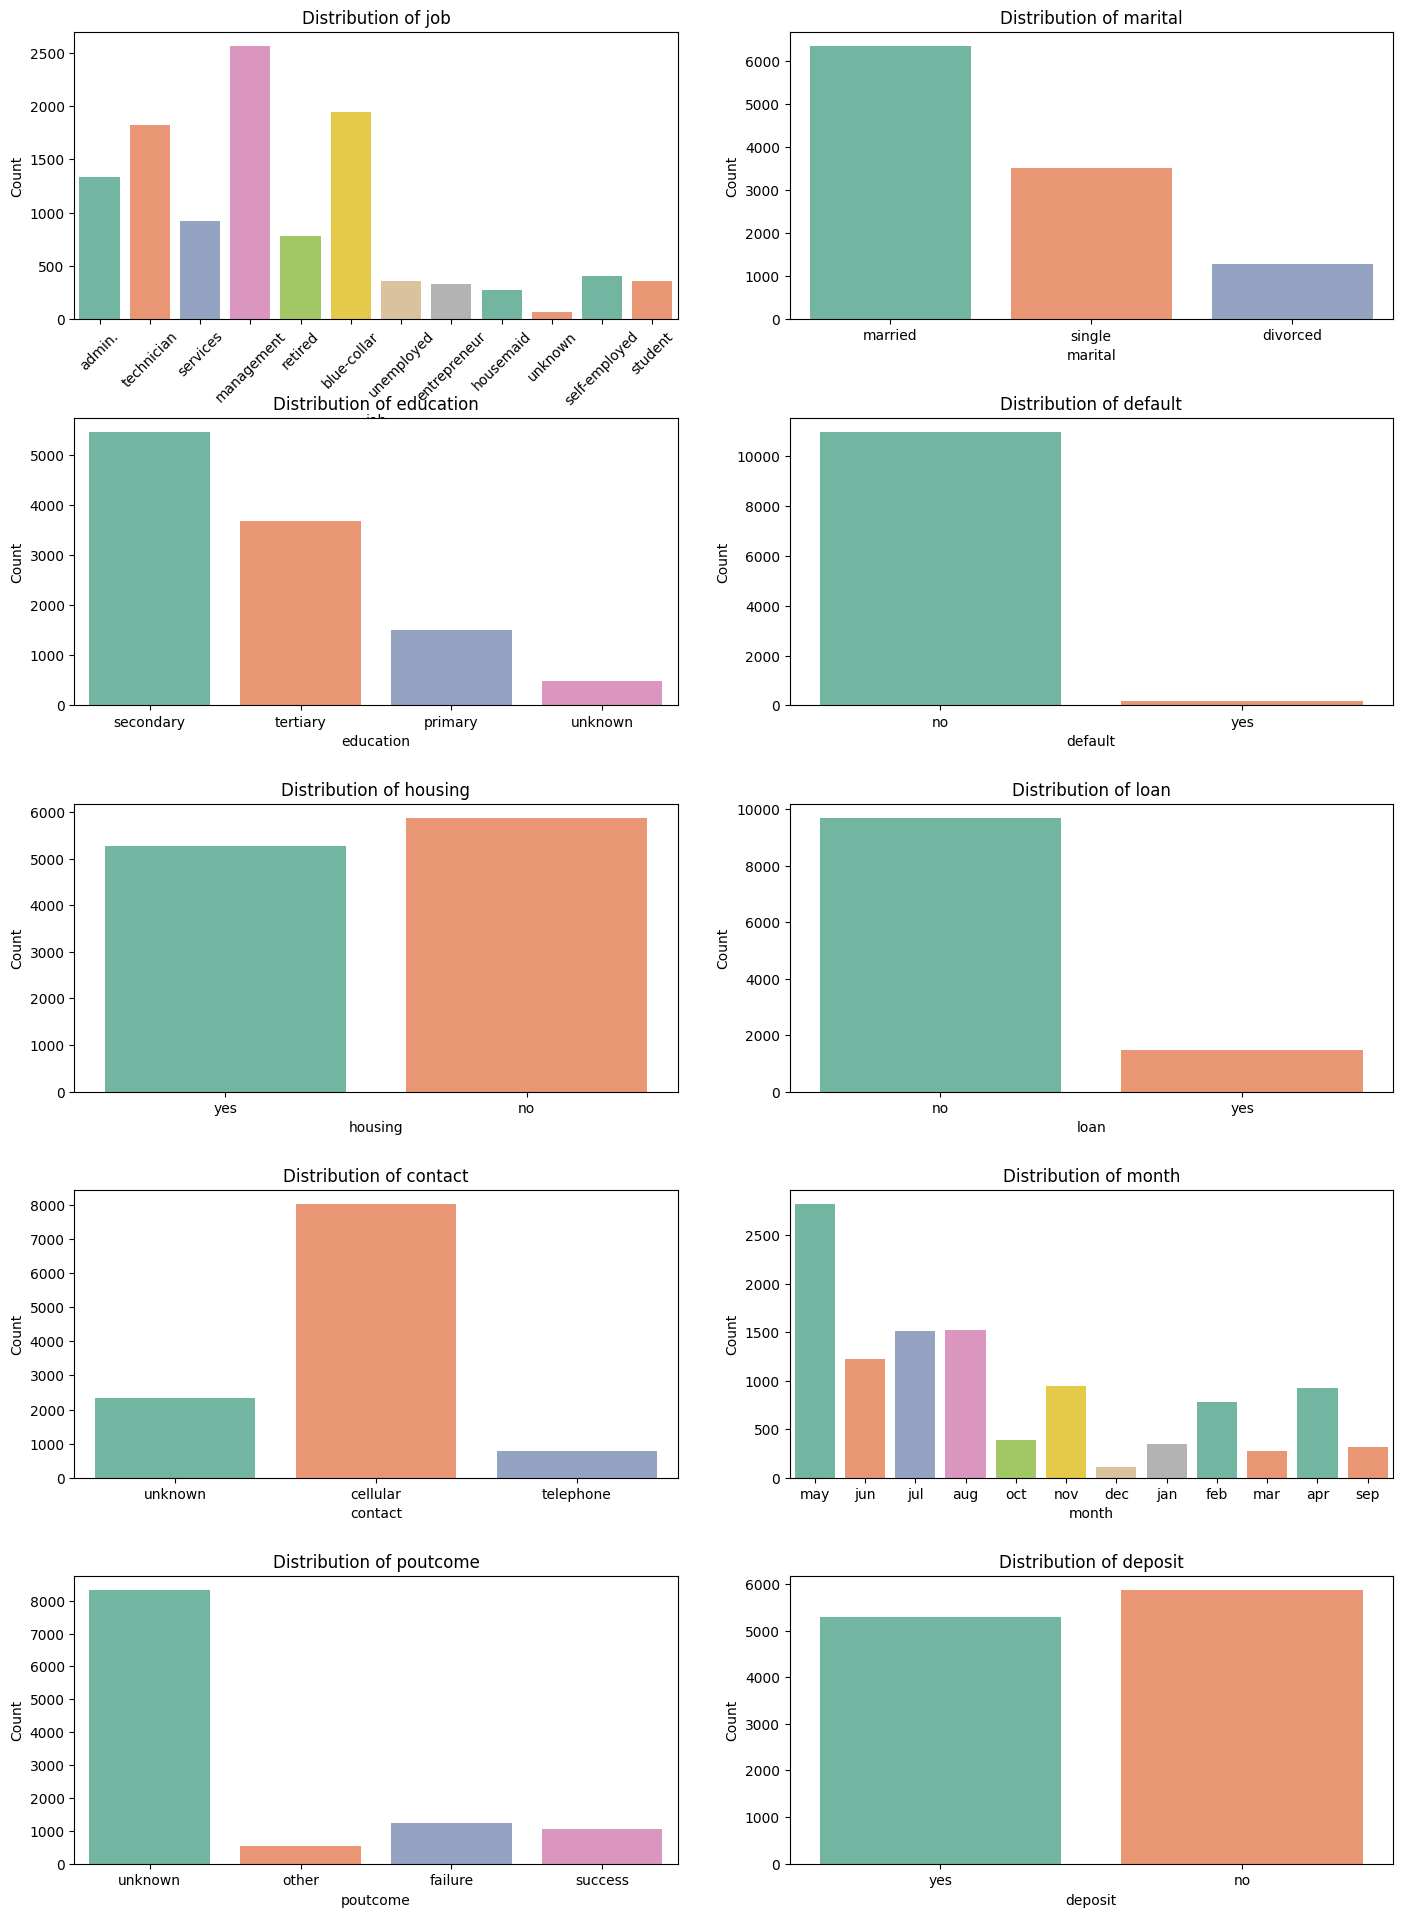

In [52]:
import warnings

warnings.filterwarnings('ignore')

categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']
palette = sns.color_palette("Set2", len(categorical_columns))

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
fig.tight_layout(pad=5.0)

for ax, column in zip(axes.flatten(), categorical_columns):
    sns.countplot(data=df, x=column, ax=ax, palette=palette)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

axes[0, 0].tick_params(axis='x', rotation=45)
plt.show()

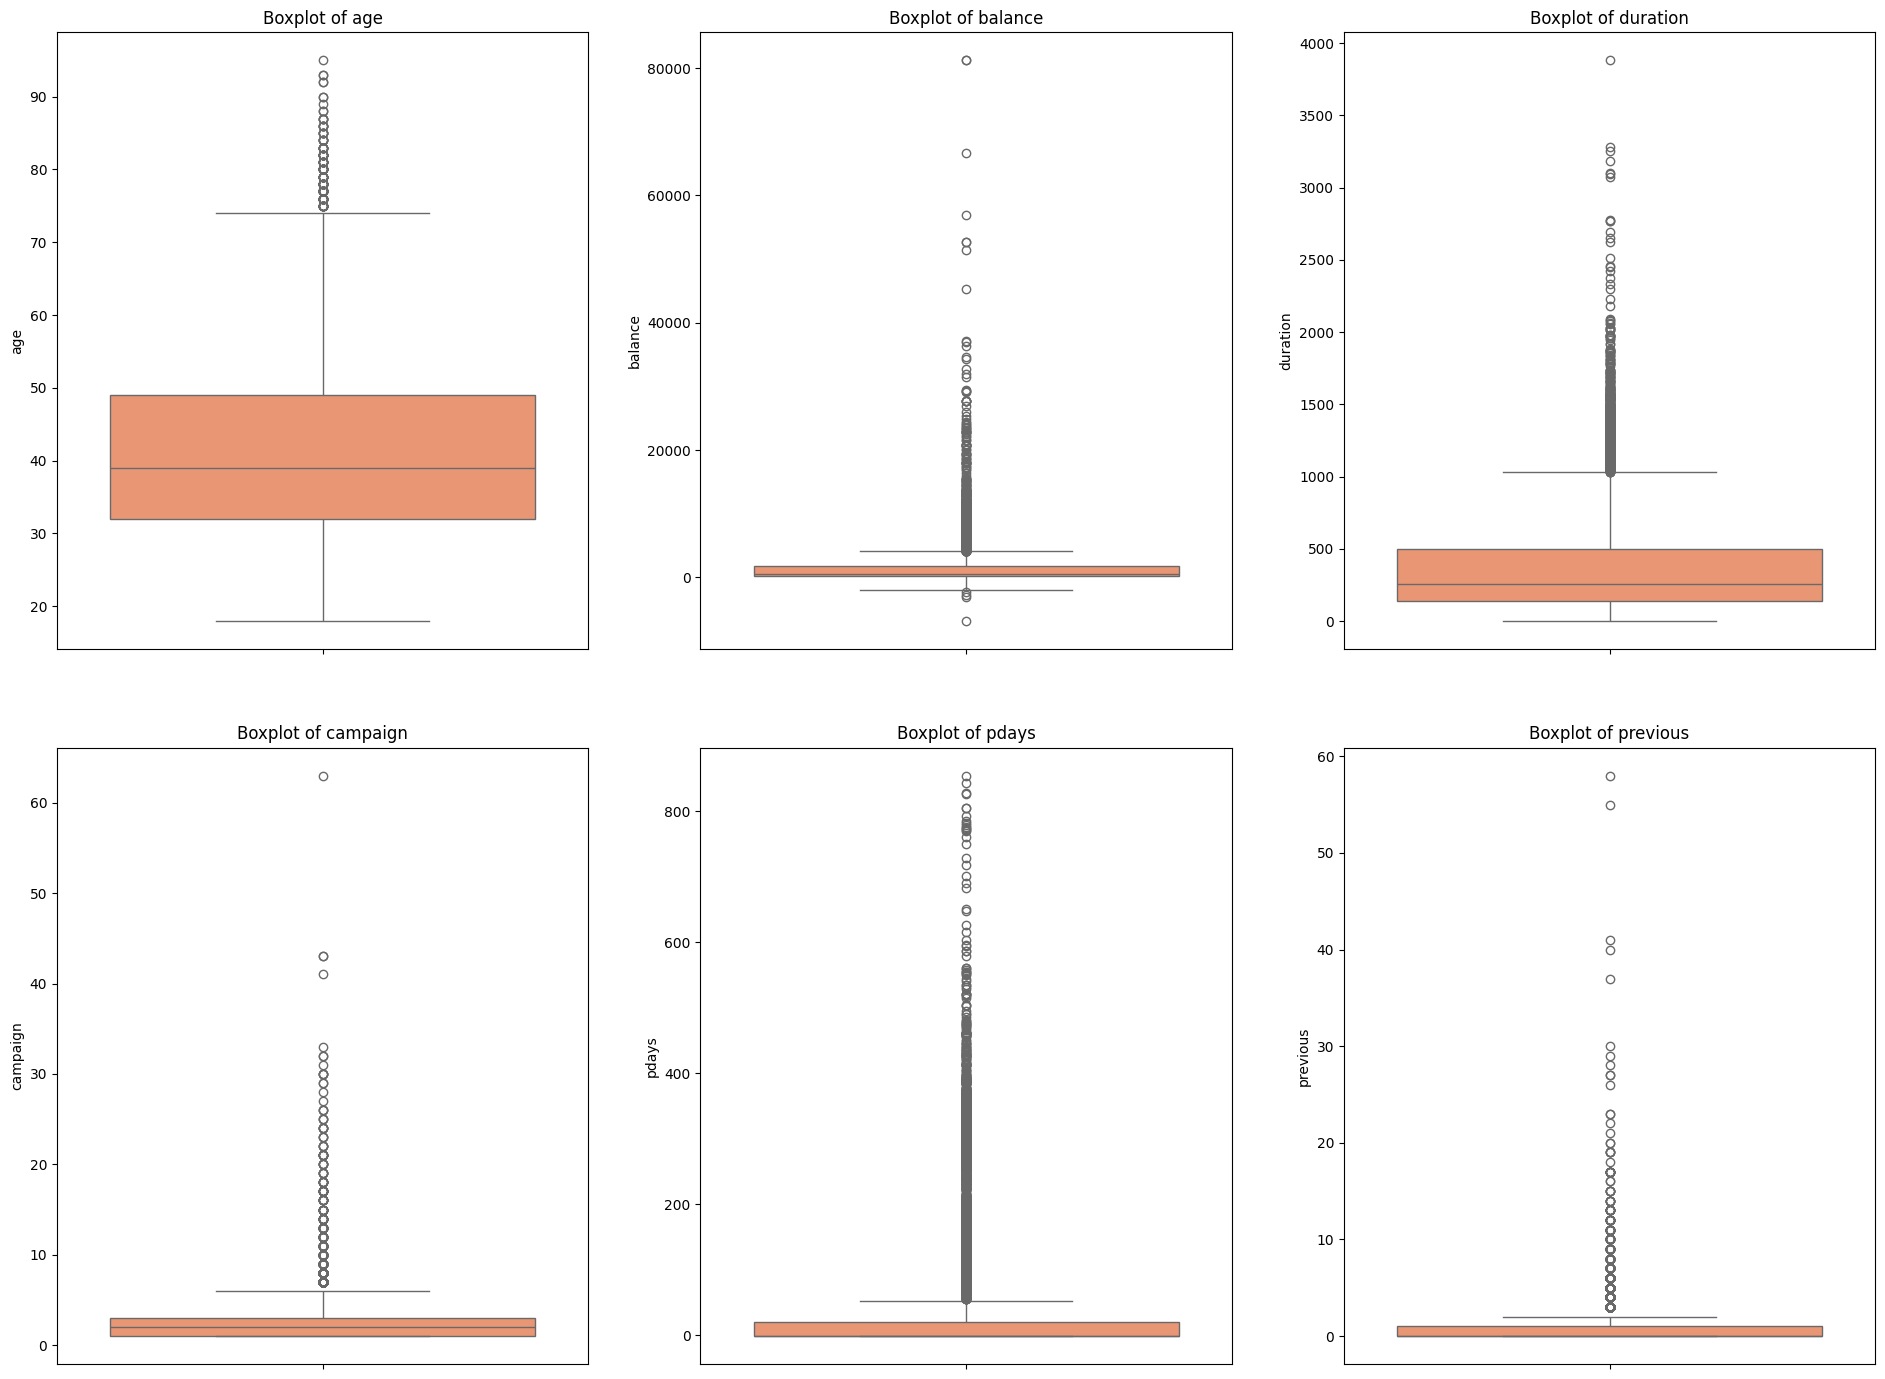

In [54]:
numerical_columns = df.select_dtypes(include=['int64']).columns
numerical_columns = numerical_columns.drop('day')

fig, axes = plt.subplots(nrows=2, ncols=len(numerical_columns)//2 + len(numerical_columns)%2, figsize=(20, 15))
fig.tight_layout(pad=5.0)
palette = sns.color_palette("Set2", len(numerical_columns))

for ax, column in zip(axes.flatten(), numerical_columns):
    sns.boxplot(data=df, y=column, ax=ax, palette=[palette[i % len(palette)]])
    ax.set_title(f'Boxplot of {column}')
    ax.set_ylabel(column)

plt.show()

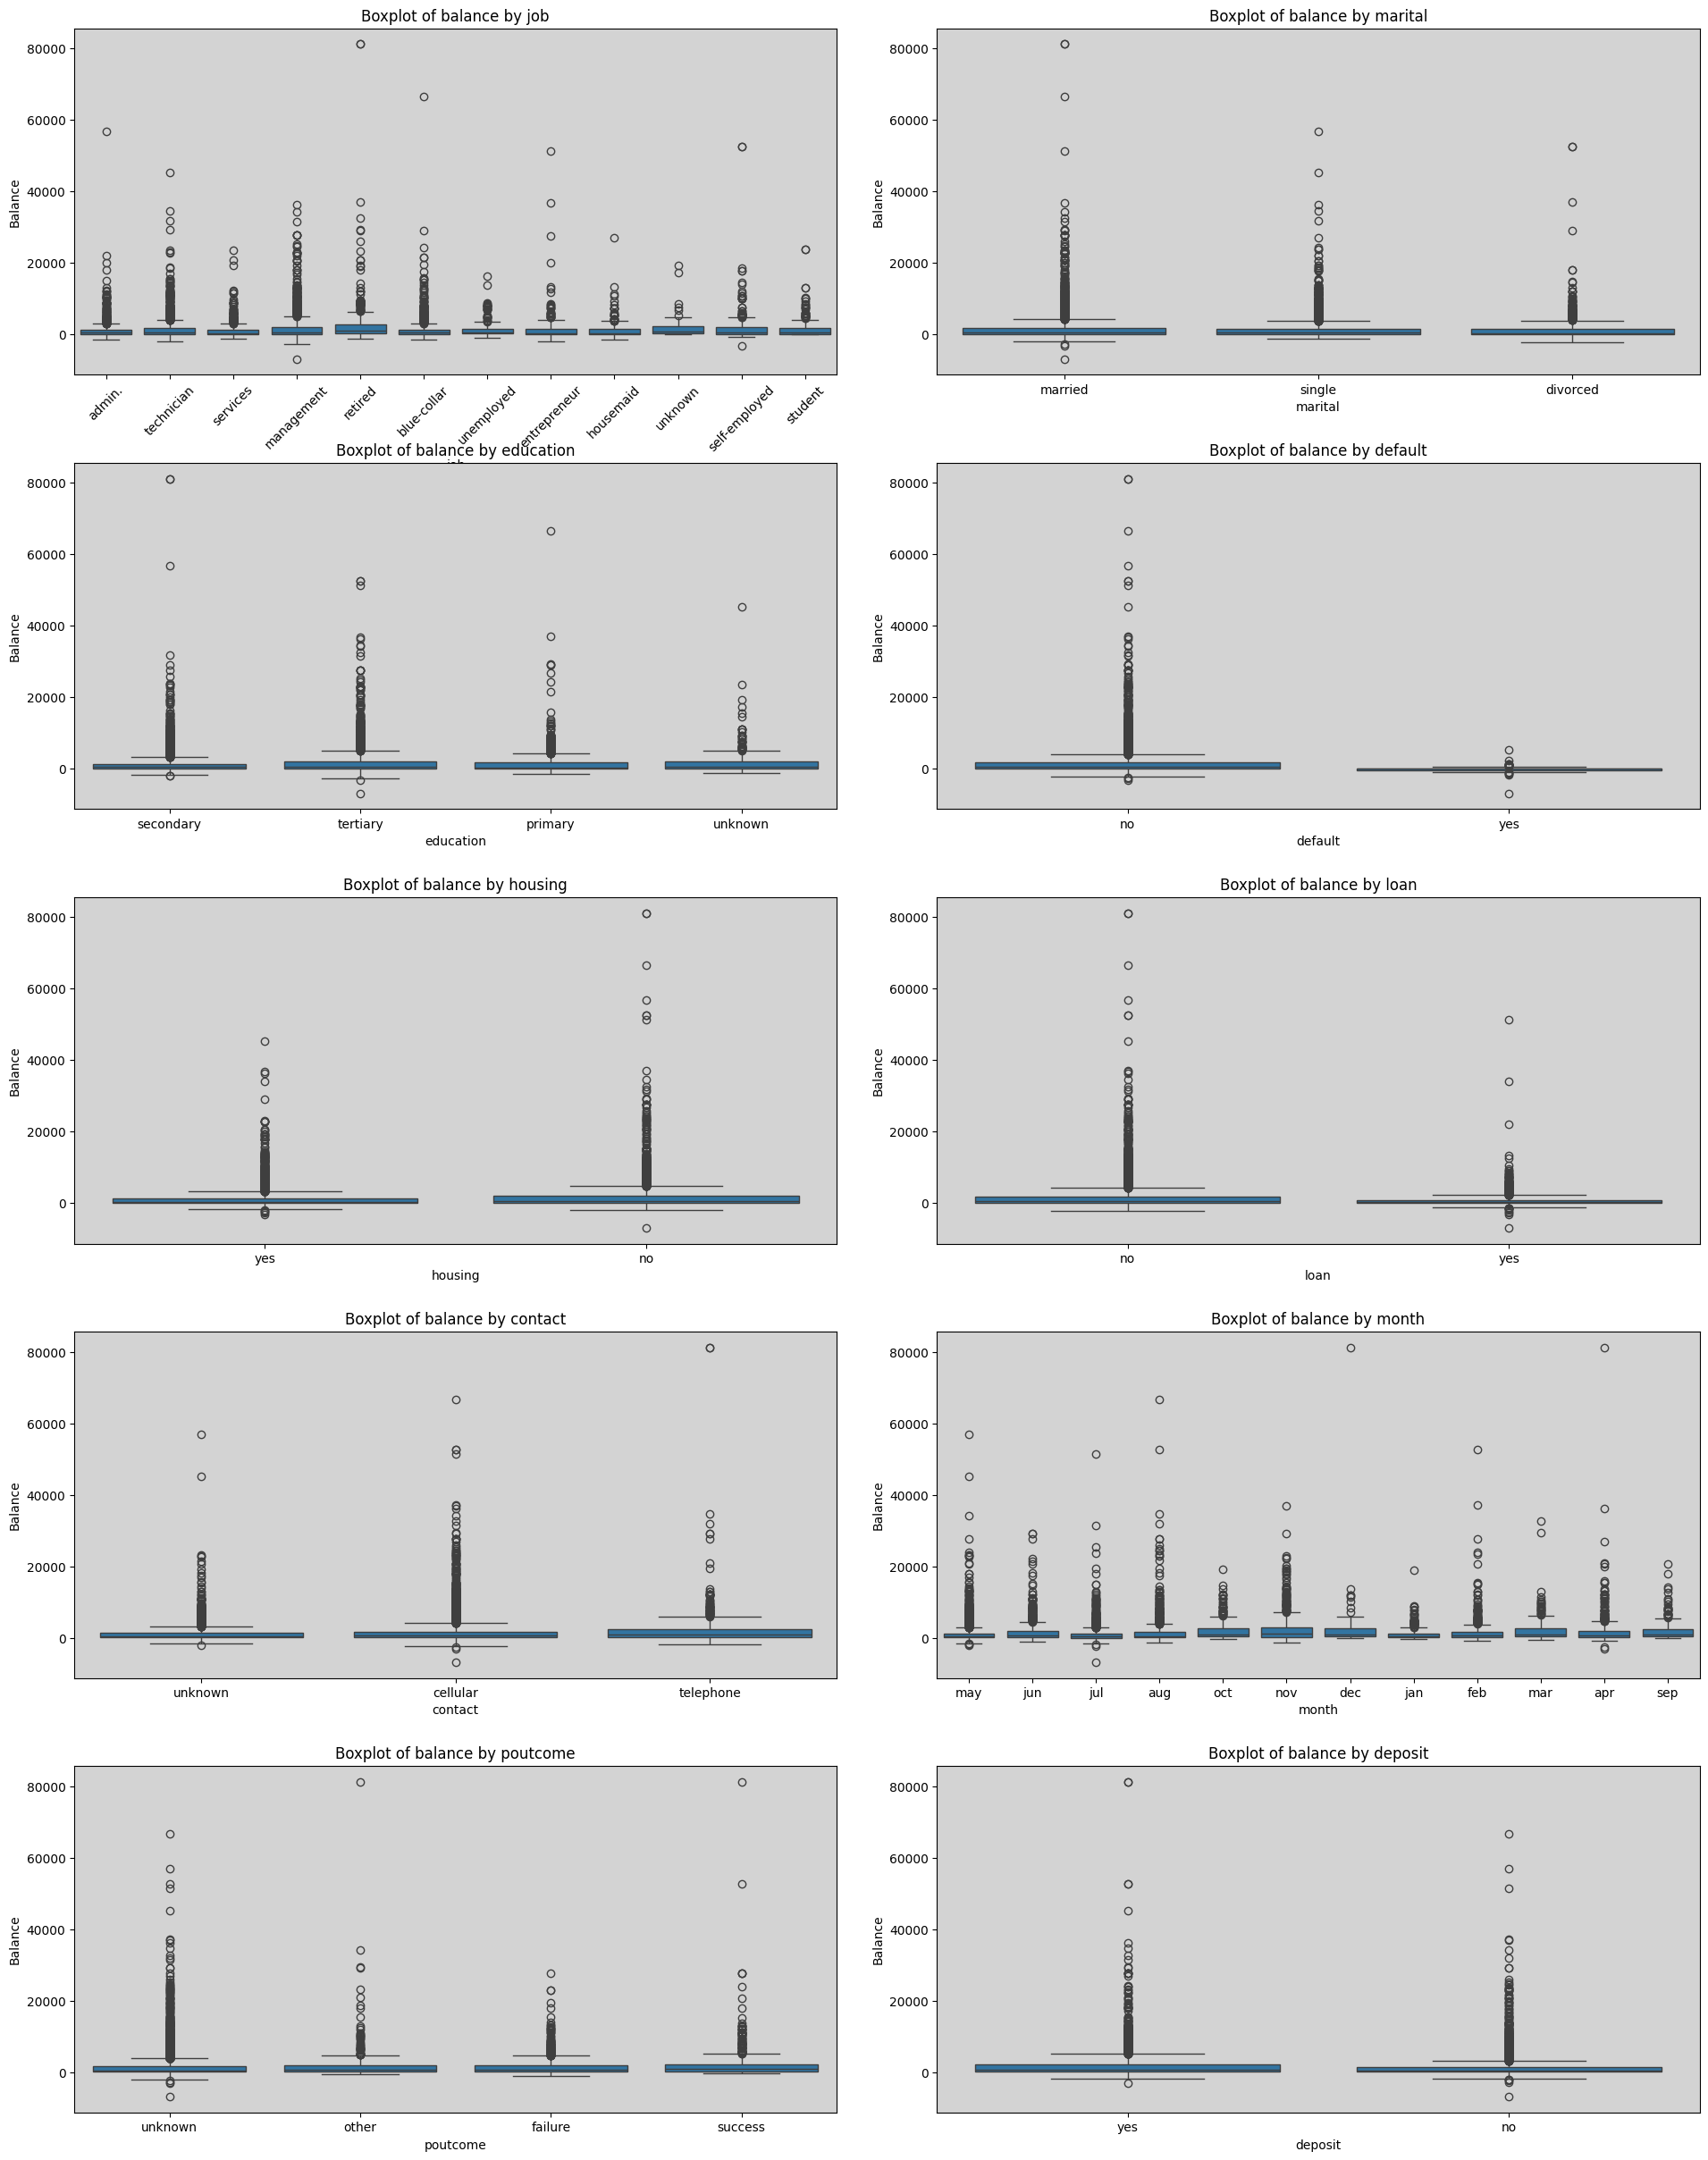

In [55]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 25))
fig.tight_layout(pad=5.0)

for ax, column in zip(axes.flatten(), categorical_columns):
    sns.boxplot(data=df, x=column, y='balance', ax=ax)
    ax.set_title(f'Boxplot of balance by {column}')
    ax.set_facecolor('lightgrey')
    ax.set_xlabel(column)
    ax.set_ylabel('Balance')
    axes[0, 0].tick_params(axis='x', rotation=45)
plt.show()

In [15]:
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

all_columns = df.select_dtypes(include=['int64', 'float64']).columns  
df1 = remove_outliers(df, all_columns)
df1

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
5,42,management,single,tertiary,no,0,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes
8,37,technician,married,secondary,no,1,yes,no,unknown,6,may,608,1,-1,0,unknown,yes
10,38,admin.,single,secondary,no,100,yes,no,unknown,7,may,786,1,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11156,34,blue-collar,single,secondary,no,-72,yes,no,cellular,7,jul,273,5,-1,0,unknown,no
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no


In [16]:
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']

label_encoder = LabelEncoder()
df2 = df1.copy()

for column in categorical_columns:
    df2[column] = label_encoder.fit_transform(df1[column])

df2

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
3,55,7,1,1,0,2476,1,0,2,5,8,579,1,-1,0,0,1
4,54,0,1,2,0,184,0,0,2,5,8,673,2,-1,0,0,1
5,42,4,2,2,0,0,1,1,2,5,8,562,2,-1,0,0,1
8,37,9,1,1,0,1,1,0,2,6,8,608,1,-1,0,0,1
10,38,0,2,1,0,100,1,0,2,7,8,786,1,-1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11156,34,1,2,1,0,-72,1,0,0,7,5,273,5,-1,0,0,0
11157,33,1,2,0,0,1,1,0,0,20,0,257,1,-1,0,0,0
11158,39,7,1,1,0,733,0,0,2,16,6,83,4,-1,0,0,0
11159,32,9,2,1,0,29,0,0,0,19,1,156,2,-1,0,0,0


In [17]:
X = df2.drop('deposit', axis=1)
y = df2['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5198, 16), (1300, 16), (5198,), (1300,))

In [18]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

accuracy_dt = (y_pred == y_test).mean()
accuracy_dt_train = (dt.predict(X_train) == y_train).mean()
print(f"Training Accuracy: {accuracy_dt_train}")
print(f"Test Accuracy: {accuracy_dt}")

Training Accuracy: 1.0
Test Accuracy: 0.7784615384615384


In [19]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy_rf = (y_pred == y_test).mean()
accuracy_rf_train = (rf.predict(X_train) == y_train).mean()
print(f"Training Accuracy: {accuracy_rf_train}")
print(f"Test Accuracy: {accuracy_rf}")

Training Accuracy: 1.0
Test Accuracy: 0.8423076923076923


In [20]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

rf_random.fit(X_train, y_train)

best_params = rf_random.best_params_
best_params

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
126 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
112 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.1

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 20,
 'bootstrap': True}

In [21]:
best_params

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 20,
 'bootstrap': True}

In [22]:
best_rf = RandomForestClassifier(**best_params, random_state=42)

best_rf.fit(X_train, y_train)

y_pred_best_rf = best_rf.predict(X_test)
accuracy_best_rf_train = (best_rf.predict(X_train) == y_train).mean()
accuracy_best_rf = (y_pred_best_rf == y_test).mean()
print(f"Training Accuracy: {accuracy_best_rf_train}")
print(f"Test Accuracy: {accuracy_best_rf}")

Training Accuracy: 0.9699884570988841
Test Accuracy: 0.8515384615384616


In [23]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)

gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)

accuracy_gb = (y_pred == y_test).mean()
accuracy_gb

np.float64(0.8507692307692307)

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_grid = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=3, n_jobs=-1, verbose=2)

gb_grid.fit(X_train, y_train)

best_params_gb = gb_grid.best_params_
best_params_gb

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=2

{'learning_rate': 0.2,
 'max_depth': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 100}

In [25]:
best_gb = GradientBoostingClassifier(**best_params_gb, random_state=42)

best_gb.fit(X_train, y_train)

y_pred_best_gb = best_gb.predict(X_test)

accuracy_best_gb_train = (best_gb.predict(X_train) == y_train).mean()
accuracy_best_gb_test = (y_pred_best_gb == y_test).mean()
print(f"Training Accuracy: {accuracy_best_gb_train}")
print(f"Test Accuracy: {accuracy_best_gb_test}")

Training Accuracy: 0.9188149288187765
Test Accuracy: 0.8538461538461538


In [26]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm = SVC(random_state=42)

svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

accuracy_svm_train = accuracy_score(y_train, svm.predict(X_train))
accuracy_svm_test = accuracy_score(y_test, y_pred_svm)
print(f"Training Accuracy: {accuracy_svm_train}")
print(f"Test Accuracy: {accuracy_svm_test}")


Training Accuracy: 0.7587533666794921
Test Accuracy: 0.7576923076923077


In [27]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

accuracy_xgb_train = (xgb.predict(X_train) == y_train).mean()
accuracy_xgb_test = (y_pred_xgb == y_test).mean()

print(f"Training Accuracy: {accuracy_xgb_train}")
print(f"Test Accuracy: {accuracy_xgb_test}")

Training Accuracy: 0.9882647171989226
Test Accuracy: 0.8384615384615385


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [28]:
from sklearn.model_selection import RandomizedSearchCV

param_grid_xgb = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid_xgb, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

xgb_random.fit(X_train, y_train)

best_params_xgb = xgb_random.best_params_
best_params_xgb

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:32] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=9, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=9, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=9, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.3, max_depth=9, min_child_weight=2, n_estimators=500, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.3, max_depth=9, min_child_weight=2, n_estimators=500, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=400, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=400, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.3, ma

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:32] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=10, min_child_weight=4, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=400, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=400, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:32] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=500, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=500, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=500, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, ma

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:32] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.2, ma

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:32] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=300, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=9, min_child_weight=1, n_estimators=400, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=9, min_child_weight=1, n_estimators=400, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=9, min_child_weight=1, n_estimators=400, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:33] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=500, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=500, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=500, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=400, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=400, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=400, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, min_child_weight=1, n_estimators=400, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_d

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:33] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, min_child_weight=1, n_estimators=400, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=400, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=400, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:33] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, min_child_weight=3, n_estimators=400, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, min_child_weight=3, n_estimators=400, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=5, n_estimators=400, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.3, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:34] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.6, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=400, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=400, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=400, subsample=0.8; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:34] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=400, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=400, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:34] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=400, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=400, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.3, max

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:34] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, min_child_weight=4, n_estimators=300, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, min_child_weight=4, n_estimators=300, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, min_child_weight=4, n_estimators=300, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, ma

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:34] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=400, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, ma

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, min_child_weight=2, n_estimators=400, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.6, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, min_child_weight=4, n_estimators=300, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, min_child_weight=4, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, min_child_weight=2, n_estimators=400, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, min_child_weight=4, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_d

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, min_child_weight=2, n_estimators=400, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.3, max_depth=10, min_child_weight=3, n_estimators=400, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.3, max_depth=10, min_child_weight=3, n_estimators=400, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=4, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=4, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=4, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, min_child_weight=3, n_estimators=200, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, min_child_weight=3, n_estimators=200, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, min_child_weight=3, n_estimators=200, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=400, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=400, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=400, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=400, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=400, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=500, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=400, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=400, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, m

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=500, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=500, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, m

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=400, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=400, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, ma

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=500, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=500, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=500, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=4, n_estimators=400, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=4, n_estimators=400, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=400, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=8, min_child_weight=3, n_estimators=500, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=500, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=8, min_child_weight=3, n_estimators=500, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_d

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.9, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=8, min_child_weight=5, n_estimators=300, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=8, min_child_weight=5, n_estimators=300, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=8, min_child_weight=5, n_estimators=300, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=400, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=400, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=400, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.1, ma

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:38] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=300, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=400, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=400, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=400, subsample=0.7; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:38] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=400, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=400, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=400, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.3, ma

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:38] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=6, min_child_weight=4, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=300, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, min_child_weight=4, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, min_child_weight=4, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_d

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


{'subsample': 0.8,
 'n_estimators': 400,
 'min_child_weight': 2,
 'max_depth': 9,
 'learning_rate': 0.01,
 'colsample_bytree': 0.8}

In [29]:
best_params_xgb

{'subsample': 0.8,
 'n_estimators': 400,
 'min_child_weight': 2,
 'max_depth': 9,
 'learning_rate': 0.01,
 'colsample_bytree': 0.8}

In [30]:
best_xgb = XGBClassifier(
    n_estimators=best_params_gb['n_estimators'],
    learning_rate=best_params_gb['learning_rate'],
    max_depth=best_params_gb['max_depth'],
    min_child_weight=best_params_gb['min_samples_leaf'],
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

best_xgb.fit(X_train, y_train)

y_pred_best_xgb = best_xgb.predict(X_test)

accuracy_best_xgb_train = (best_xgb.predict(X_train) == y_train).mean()
accuracy_best_xgb_test = (y_pred_best_xgb == y_test).mean()

print(f"Training Accuracy: {accuracy_best_xgb_train}")
print(f"Test Accuracy: {accuracy_best_xgb_test}")

Training Accuracy: 0.8988072335513659
Test Accuracy: 0.8492307692307692


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:33:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


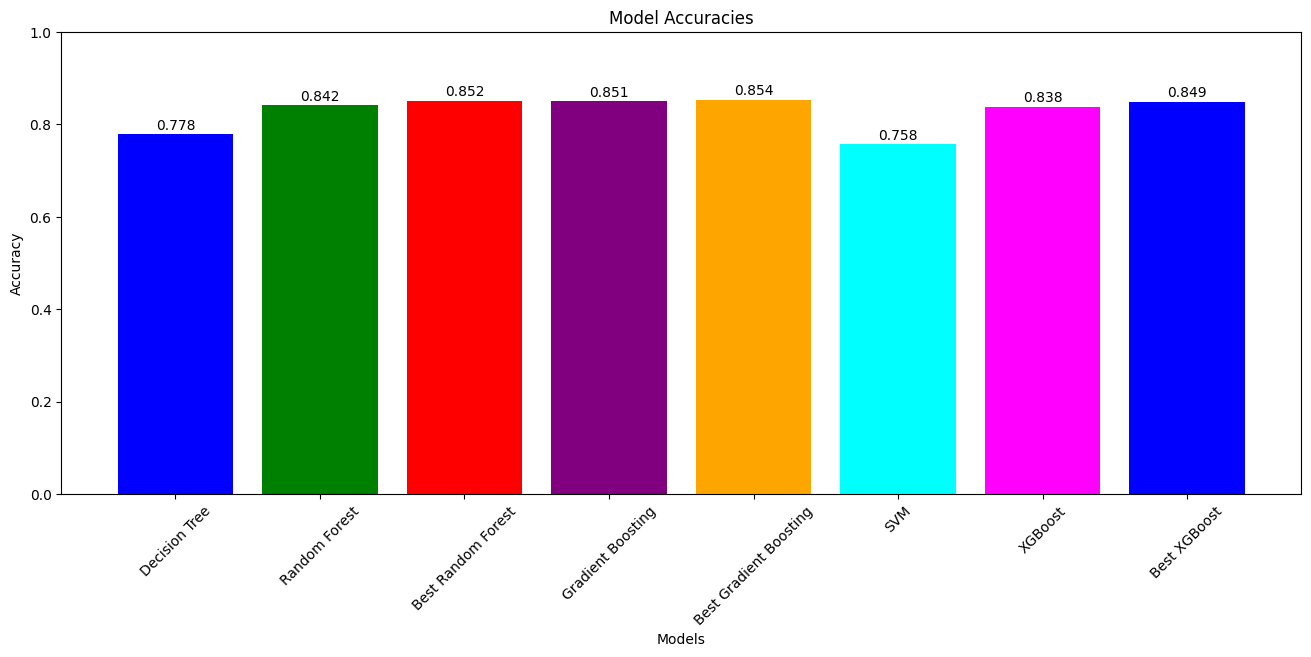

In [33]:
# Model names and their corresponding accuracies
models = ['Decision Tree', 'Random Forest', 'Best Random Forest', 'Gradient Boosting', 'Best Gradient Boosting', 'SVM', 'XGBoost', 'Best XGBoost']
accuracies = [accuracy_dt, accuracy_rf, accuracy_best_rf, accuracy_gb, accuracy_best_gb_test, accuracy_svm_test, accuracy_xgb_test, accuracy_best_xgb_test]

plt.figure(figsize=(16, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta'])

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
    
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.ylim(0, 1)
plt.show()

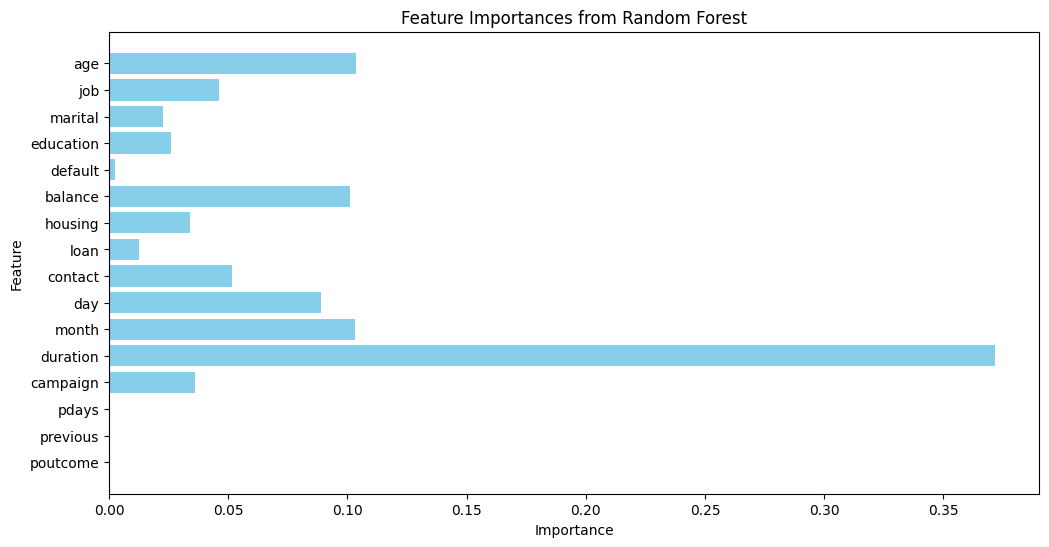

      Feature  Importance
11   duration    0.371533
0         age    0.103558
10      month    0.103057
5     balance    0.101240
9         day    0.088972
8     contact    0.051515
1         job    0.046337
12   campaign    0.035983
6     housing    0.034008
3   education    0.026090
2     marital    0.022760
7        loan    0.012488
4     default    0.002460
13      pdays    0.000000
14   previous    0.000000
15   poutcome    0.000000


In [39]:
importances = rf.feature_importances_

plt.figure(figsize=(12, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()
feature_names = X.columns

feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

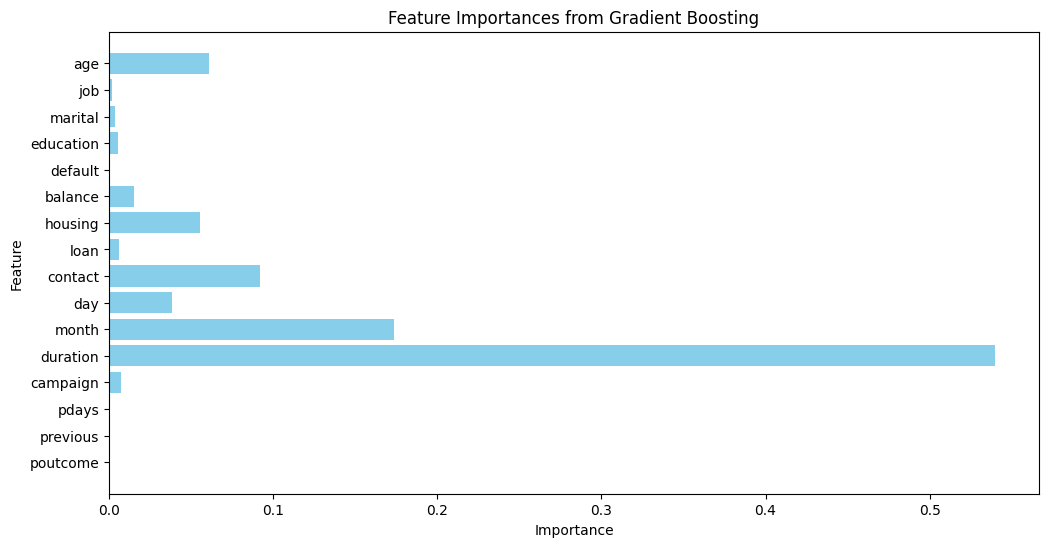

      Feature  Importance
11   duration    0.539676
10      month    0.173684
8     contact    0.091890
0         age    0.060772
6     housing    0.055244
9         day    0.038186
5     balance    0.015332
12   campaign    0.007425
7        loan    0.006039
3   education    0.005564
2     marital    0.003655
1         job    0.002085
4     default    0.000448
13      pdays    0.000000
14   previous    0.000000
15   poutcome    0.000000


In [40]:
# Calculate feature importances for Gradient Boosting
importances_gb = gb.feature_importances_

# Plotting the feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_names, importances_gb, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Gradient Boosting')
plt.gca().invert_yaxis()
plt.show()

# Creating a DataFrame for better visualization
feature_importances_gb = pd.DataFrame({'Feature': feature_names, 'Importance': importances_gb})
feature_importances_gb = feature_importances_gb.sort_values(by='Importance', ascending=False)

print(feature_importances_gb)

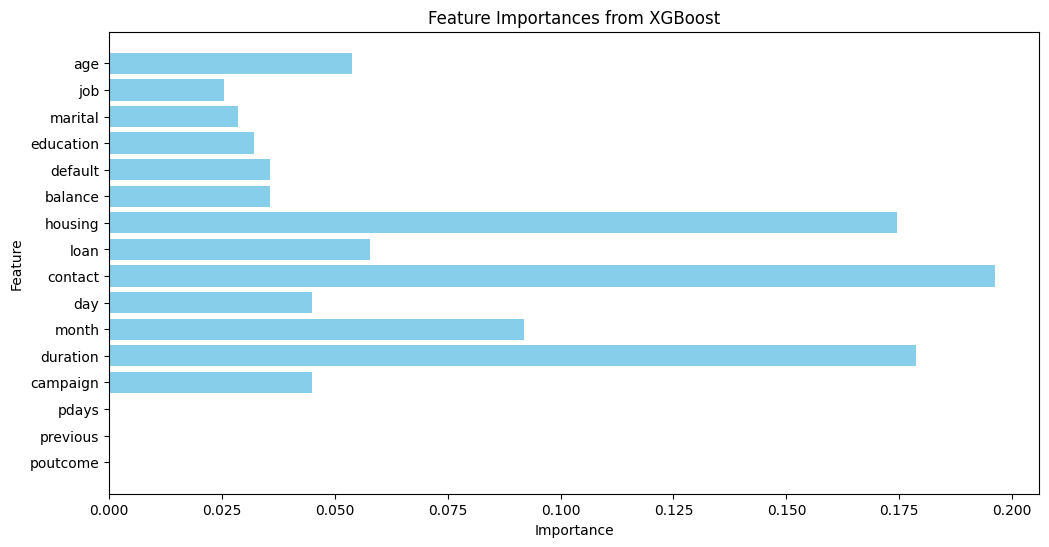

      Feature  Importance
8     contact    0.196140
11   duration    0.178669
6     housing    0.174417
10      month    0.091869
7        loan    0.057889
0         age    0.053861
12   campaign    0.044961
9         day    0.044915
4     default    0.035653
5     balance    0.035594
3   education    0.031994
2     marital    0.028540
1         job    0.025497
13      pdays    0.000000
14   previous    0.000000
15   poutcome    0.000000


In [41]:
importances_xgb = best_xgb.feature_importances_

# Plotting the feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_names, importances_xgb, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from XGBoost')
plt.gca().invert_yaxis()
plt.show()

# Creating a DataFrame for better visualization
feature_importances_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importances_xgb})
feature_importances_xgb = feature_importances_xgb.sort_values(by='Importance', ascending=False)

print(feature_importances_xgb)